In [1]:
#conda activate torch-xla-nightly
#export XRT_TPU_CONFIG="tpu_worker;0;$10.0.101.2:8470"
#git init
#git remote add origin https://github.com/nosound2/RSNA-Hemorrhage
#git pull origin master
#git config remote.origin.push HEAD
#gcloud config set compute/zone europe-west4-a
#gcloud auth login
#gcloud config set project endless-empire-239015
#pip install kaggle
#mkdir .kaggle
#gsutil cp gs://recursion-double-strand/kaggle-keys/kaggle.json ~/.kaggle
#chmod 600 /home/zahar_chikishev/.kaggle/kaggle.json
#kaggle competitions download rsna-intracranial-hemorrhage-detection -f stage_1_train.csv
#sudo apt install unzip
#unzip stage_1_train.csv.zip
#kaggle kernels output xhlulu/rsna-generate-metadata-csvs -p .
#gsutil cp gs://rsna-hemorrhage/yuvals/* .

#export XRT_TPU_CONFIG="tpu_worker;0;10.0.101.2:8470"; conda activate torch-xla-nightly; jupyter notebook

# 35.204.242.164

In [2]:
import sys

from pathlib import Path
from PIL import ImageDraw, ImageFont, Image
from matplotlib import patches, patheffects
import time
from random import randint
import numpy as np
import pandas as pd
import pickle

from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, LabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error,log_loss
from scipy.stats import ks_2samp

import pdb

import scipy as sp
from tqdm import tqdm, tqdm_notebook

import os
import glob

import torch

CLOUD = not torch.cuda.is_available()
CLOUD_SINGLE = False

if not CLOUD:
    torch.cuda.current_device()

import torch.nn as nn
import torch.utils.data as D
import torch.nn.functional as F
import torch.utils as U

import torchvision
from torchvision import transforms as T
from torchvision import models as M

import matplotlib.pyplot as plt

if CLOUD:
    PATH = Path('/home/zahar_chikishev')
    PATH_WORK = Path('/home/zahar_chikishev/running')
else:
    PATH = Path('C:/StudioProjects/Hemorrhage')
    PATH_WORK = Path('C:/StudioProjects/Hemorrhage/running')

from collections import defaultdict, Counter
import random
import seaborn as sn

pd.set_option("display.max_columns", 100)

all_ich = ['any','epidural','intraparenchymal','intraventricular','subarachnoid','subdural']
class_weights = 6.0*np.array([2,1,1,1,1,1])/7.0

if CLOUD:
    import torch_xla
    import torch_xla.distributed.data_parallel as dp
    import torch_xla.utils as xu
    import torch_xla.core.xla_model as xm
    
    from typing import Collection

VERSION = 20

In [3]:
if CLOUD:
    device = xm.xla_device()
    #device = 'cpu'
    MAX_DEVICES = 1 if CLOUD_SINGLE else 8
    bs = 100
else:
    device = 'cuda'
    #device = 'cpu'
    MAX_DEVICES = 1
    bs = 10

if CLOUD and (not CLOUD_SINGLE):
    devices = xm.get_xla_supported_devices(max_devices=MAX_DEVICES)

In [4]:
SEED = 2351

def setSeeds(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

setSeeds(SEED)
torch.backends.cudnn.deterministic = True

In [5]:
cols_cat, cols_float = pickle.load(open(PATH_WORK/'covs','rb'))
meta_cols = cols_cat + cols_float

In [6]:
if False:
    filename = PATH_WORK/'indexes_file.pkl'
    all_idx, train_ids, val_ids = pickle.load(open(filename,'rb'))

    train_md = pd.read_csv(PATH_WORK/'train_md.csv').sort_values(['SeriesInstanceUID','pos_idx'])
    train_md['img_id'] = train_md.SOPInstanceUID.str.split('_').apply(lambda x: x[1])

    trn_data = train_md.loc[train_md.img_id.isin(all_idx[train_ids])].reset_index(drop=True)
    val_data = train_md.loc[train_md.img_id.isin(all_idx[val_ids])].reset_index(drop=True)

    assert len(trn_data.SeriesInstanceUID.unique()) + len(val_data.SeriesInstanceUID.unique()) \
        == len(train_md.SeriesInstanceUID.unique())

    assert len(trn_data.PatientID.unique()) + len(val_data.PatientID.unique()) \
        >= len(train_md.PatientID.unique())

    ids_df = pd.DataFrame(all_idx, columns = ['img_id'])
    ids_df = ids_df.join(train_md[['img_id','SeriesInstanceUID','pos_idx']].set_index('img_id'), on = 'img_id')

    assert len(ids_df.SeriesInstanceUID.unique()) == 19530
    
    pickle.dump((trn_data,val_data,ids_df), open(PATH_WORK/'train.post.processed.1','wb'))
else:
    trn_data,val_data,ids_df = pickle.load(open(PATH_WORK/'train.post.processed.1','rb'))

In [7]:
if False:
    test_md = pd.read_csv(PATH_WORK/'test_md.csv').sort_values(['SeriesInstanceUID','pos_idx'])
    test_md['img_id'] = test_md.SOPInstanceUID.str.split('_').apply(lambda x: x[1])

    filename = PATH_WORK/'test_indexes.pkl'
    test_ids = pickle.load(open(filename,'rb'))

    test_ids_df = pd.DataFrame(test_ids, columns = ['img_id'])
    test_ids_df = test_ids_df.join(test_md[['img_id','SeriesInstanceUID','pos_idx']].set_index('img_id'), on = 'img_id')

    assert len(test_ids_df.SeriesInstanceUID.unique()) == 2214
    
    pickle.dump((test_md,test_ids_df), open(PATH_WORK/'test.post.processed.1','wb'))
else:
    test_md,test_ids_df = pickle.load(open(PATH_WORK/'test.post.processed.1','rb'))

In [8]:
if False:
    print(pd.concat([test_md[meta_cols].mean(0),
                     trn_data[meta_cols].mean(0),
                     val_data[meta_cols].mean(0)], axis=1))

# Pre-processing

In [9]:
if False:
    filename = PATH_WORK/'model_Densenet161_3_vehrsion_basic_classifier_type_features_train_split_2.pkl'
    feats = pickle.load(open(filename,'rb'))

    for series_id in tqdm(ids_df.SeriesInstanceUID.unique()):
        mask = torch.BoolTensor(ids_df.SeriesInstanceUID.values == series_id)
        feats_id = feats[mask]
        pickle.dump(feats_id, open(PATH_WORK/'features/densenet161_v3/train/{}'.format(series_id),'wb'))


    filename = PATH_WORK/'model_Densenet161_3_vehrsion_basic_classifier_type_features_test_split_2.pkl'
    feats = pickle.load(open(filename,'rb'))

    for series_id in tqdm(test_ids_df.SeriesInstanceUID.unique()):
        mask = torch.BoolTensor(test_ids_df.SeriesInstanceUID.values == series_id)
        feats_id = feats[mask]
        pickle.dump(feats_id, open(PATH_WORK/'features/densenet161_v3/test/{}'.format(series_id),'wb'))

# Dataset

In [10]:
#path = PATH_WORK/'features/densenet161_v3/train/ID_000a935543'
#feats1 = pickle.load(open(path,'rb'))

In [11]:
all_black = '006d4432e'

path = PATH_WORK/'features/densenet161_v3/train/ID_992b567eb6'
black_feats = pickle.load(open(path,'rb'))[41]

#black_feats = torch.zeros(black_feats.shape)

In [12]:
class RSNA_DataSet(D.Dataset):
    def __init__(self, metadata, ids_df, mode='train', bs=None):
        
        super(RSNA_DataSet, self).__init__()
        
        md = metadata.copy()
        md = md.reset_index(drop=True)
        series = md.SeriesInstanceUID.unique()
        
        samples_add = 0
        if (mode != 'train') and not DATA_SMALL:
            batch_num = -((-len(series))//(bs*MAX_DEVICES))
            samples_add = batch_num*bs*MAX_DEVICES - len(series)
            print('adding dummy serieses', samples_add)
        
        #self.records = df.to_records(index=False)
        self.mode = mode
        self.real = np.concatenate([np.repeat(True,len(series)),np.repeat(False,samples_add)])
        self.series = np.concatenate([series,np.repeat(series[0],samples_add)])
        self.metadata = md
        self.ids_df = ids_df
    
    def __getitem__(self, index):
        
        series_id = self.series[index]
        df = self.metadata.loc[self.metadata.SeriesInstanceUID == series_id].reset_index(drop=True)
        
        folder = 'test' if self.mode == 'test' else 'train'
        path = PATH_WORK/'features/densenet161_v3/{}/{}'.format(folder,series_id)
        feats = pickle.load(open(path,'rb'))
        ids_df_sub = self.ids_df.loc[self.ids_df.SeriesInstanceUID.values == series_id]
        
        if feats.shape[0] > len(df):
            mask_dup = ~ids_df_sub.img_id.duplicated().values
            ids_df_sub = ids_df_sub.loc[mask_dup]
            feats = feats[torch.BoolTensor(mask_dup)]
        
        assert feats.shape[0] == len(df)
        assert len(ids_df_sub) == len(df)
        assert np.all(ids_df_sub.img_id.isin(df.img_id).values)
        order = np.argsort(ids_df_sub.pos_idx.values)
        assert np.all(ids_df_sub.img_id.values[order] == df.img_id.values)
        feats = feats[torch.LongTensor(order)]
        
        feats = torch.cat([feats, torch.Tensor(df[meta_cols].values)], dim=1)
        target = torch.Tensor(df[all_ich].values)
        
        offset = np.random.randint(0, 61 - feats.shape[0])
        #offset = 0
        if offset > 0:
            dummy_row = torch.cat([black_feats, torch.Tensor(df.head(1)[meta_cols].values).squeeze()])
            #dummy_row = torch.cat([black_feats, torch.zeros(len(meta_cols))])
            feats = torch.cat([dummy_row.repeat(offset,1), feats], dim=0)
            target = torch.cat([torch.zeros((offset, len(all_ich))), target], dim=0)
        if (60 - len(df) - offset) > 0:
            dummy_row = torch.cat([black_feats, torch.Tensor(df.tail(1)[meta_cols].values).squeeze()])
            #dummy_row = torch.cat([black_feats, torch.zeros(len(meta_cols))])
            feats = torch.cat([feats, dummy_row.repeat(60 - len(df) - offset,1)], dim=0)
            target = torch.cat([target, torch.zeros((60 - len(df) - offset, len(all_ich)))], dim=0)
        
        assert feats.shape[0] == 60
        assert target.shape[0] == 60
        
        feats = feats.transpose(1,0)
        
        idx = index
        if not self.real[index]: idx = -1
        
        if self.mode == 'train':
            return feats, target
        else:
            return feats, target, idx, offset
    
    def __len__(self):
        return len(self.series) if not DATA_SMALL else int(0.01*len(self.series))

In [13]:
def getCurrentBatch(fold=0):
    sel_batch = None
    for filename in os.listdir(PATH_WORK/'models'):
        splits = filename.split('.')
        if int(splits[2][1]) != fold: continue
        if int(splits[3][1:]) != VERSION: continue
        if sel_batch is None:
            sel_batch = int(splits[1][1:])
        else:
            sel_batch = max(sel_batch, int(splits[1][1:]))
    return sel_batch

def modelFileName(fold=0, batch = 1, return_last = False, return_next = False):
    sel_batch = batch
    if return_last or return_next:
        sel_batch = getCurrentBatch(fold)
        if return_last and sel_batch is None:
            return None
        if return_next:
            if sel_batch is None: sel_batch = 1
            else: sel_batch += 1
    
    return 'model.b{}.f{}.v{}'.format(sel_batch, fold, VERSION)

# Model

In [14]:
class _Loss(nn.Module):
    def __init__(self, size_average=None, reduce=None, reduction='mean'):
        super(_Loss, self).__init__()
        if size_average is not None or reduce is not None:
            self.reduction = _Reduction.legacy_get_string(size_average, reduce)
        else:
            self.reduction = reduction

class BCEWithLogitsLoss(_Loss):
    __constants__ = ['weight', 'pos_weight', 'reduction']

    def __init__(self, weight=None, size_average=None, reduce=None, reduction='mean', pos_weight=None):
        super(BCEWithLogitsLoss, self).__init__(size_average, reduce, reduction)
        self.register_buffer('weight', weight)
        self.register_buffer('pos_weight', pos_weight)
    
    def forward(self, input, target):
        #((torch.log(1+torch.exp(input)) - target*input)*self.weight).mean()
        return F.binary_cross_entropy_with_logits(input.squeeze(), target,
                                                  self.weight,
                                                  pos_weight=self.pos_weight,
                                                  reduction=self.reduction)

In [15]:
class FeatProduct(nn.Module):
    def __init__(self, in_feature, out_feature):
        super(FeatProduct, self).__init__()
        self.in_feature = in_feature
        self.out_feature = out_feature
        self.weight = nn.Parameter(torch.Tensor(out_feature, in_feature))
        self.bias = nn.Parameter(torch.Tensor(out_feature))
        nn.init.xavier_uniform_(self.weight)
        nn.init.uniform_(self.bias)

    def forward(self, x):
        output = F.linear(x, self.weight) + self.bias
        return output

In [16]:
def bn_drop_lin(n_in:int, n_out:int, bn:bool=True, p:float=0., actn=None):
    "Sequence of batchnorm (if `bn`), dropout (with `p`) and linear (`n_in`,`n_out`) layers followed by `actn`."
    layers = [nn.BatchNorm1d(n_in)] if bn else []
    if p != 0: layers.append(nn.Dropout(p))
    layers.append(nn.Linear(n_in, n_out))
    if actn is not None: layers.append(actn)
    return layers

In [17]:
class TabularModel(nn.Module):
    "Basic model for tabular data."
    def __init__(self, n_cont:int, out_sz:int, layers, ps=None,
                 emb_drop:float=0., use_bn:bool=True, bn_final:bool=False, feat_sz=2208, fc_drop_p=0.3):
        super().__init__()
        self.bn_cont = nn.BatchNorm1d(feat_sz + n_cont)
        self.n_cont = n_cont
        sizes = self.get_sizes(layers, out_sz)
        actns = [nn.ReLU(inplace=True) for _ in range(len(sizes)-2)] + [None]
        layers = []
        for i,(n_in,n_out,dp,act) in enumerate(zip(sizes[:-1],sizes[1:],[0.]+ps,actns)):
            layers += bn_drop_lin(n_in, n_out, bn=use_bn and i!=0, p=dp, actn=act)
        if bn_final: layers.append(nn.BatchNorm1d(sizes[-1]))
        self.layers = nn.Sequential(*layers)
        self.feat_product = FeatProduct(feat_sz + n_cont, 20)
        self.fc_drop = nn.Dropout(p=fc_drop_p)
        self.relu = nn.ReLU(inplace=True)
        self.conv2D_1 = nn.Conv2d(1,32,(feat_sz + n_cont,1))
        self.conv2D_2 = nn.Conv2d(1,32,(feat_sz + n_cont,5),padding=(0,2))
        self.bn_cont1 = nn.BatchNorm1d(64)
        self.conv1D_1 = nn.Conv1d(64,64,3,padding=1)
        self.conv1D_2 = nn.Conv1d(64,6,3,padding=1)
        self.bn_cont2 = nn.BatchNorm1d(64)
        self.bn_cont3 = nn.BatchNorm1d(6)

    def get_sizes(self, layers, out_sz):
        return [1200] + layers + [out_sz]

    def forward(self, x) -> torch.Tensor:
        x = self.bn_cont(x) # bs,2208,60
        #x = x.transpose(1,2) # bs,60,2208
        x = x.reshape(x.shape[0],1,x.shape[1],x.shape[2]) # bs,1,2208,60
        x = torch.cat([self.conv2D_1(x).squeeze(), self.conv2D_2(x).squeeze()], dim=1) # bs,64,60
        x = self.relu(x)
        x = self.bn_cont1(x)
        x = self.conv1D_1(x)
        x = self.relu(x)
        x = self.bn_cont2(x)
        x = self.conv1D_2(x)
        x = self.relu(x)
        x = self.bn_cont3(x) # bs,6,60
        #x = self.fc_drop(x)
        #x = self.feat_product(x)
        #x = x.reshape(x.shape[0],-1)
        #x = self.layers(x)
        #x = x.reshape(x.shape[0],60,6)
        x = x.transpose(1,2) # bs,60,6
        return x

# Training

In [18]:
def train_loop_fn(model, loader, device, context = None):
    
    if CLOUD and (not CLOUD_SINGLE):
        tlen = len(loader._loader._loader)
        OUT_LOSS = 1000
        OUT_TIME = 5
        generator = loader
        device_num = int(str(device)[-1])
        dataset = loader._loader._loader.dataset
    else:
        tlen = len(loader)
        OUT_LOSS = 10
        OUT_TIME = 1
        generator = enumerate(loader)
        device_num = 1
        dataset = loader.dataset
    
    #print('Start training {}'.format(device), 'batches', tlen)
    
    criterion = BCEWithLogitsLoss(weight = torch.Tensor(class_weights).to(device))
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay, betas=(0.9, 0.99))
    
    model.train()
    
    if CLOUD:
        tracker = xm.RateTracker()

    tloss = 0
    tloss_count = 0
    
    st = time.time()
    for i, (x, y) in generator:
        if (not CLOUD) or CLOUD_SINGLE:
            x = x.to(device)
            y = y.to(device)
        optimizer.zero_grad()
        output = model(x)
        
        loss = criterion(output, y)
        loss.backward()
        
        tloss += len(y)*loss.cpu().detach().item()
        tloss_count += len(y)
        
        if CLOUD or CLOUD_SINGLE:
            xm.optimizer_step(optimizer)
            if CLOUD_SINGLE:
                xm.mark_step()
        else:
            optimizer.step()
        
        if CLOUD:
            tracker.add(len(y))
        
        st_passed = time.time() - st
        if (i+1)%OUT_TIME == 0 and device_num == 1:
            #print(torch_xla._XLAC._xla_metrics_report())
            print('Batch {} device: {} time passed: {:.3f} time per batch: {:.3f}'
                .format(i+1, device, st_passed, st_passed/(i+1)))
        
        del loss, output, y, x
    
    return tloss, tloss_count

In [19]:
@torch.no_grad()
def val_loop_fn(model, loader, device, context = None):
    
    if CLOUD and (not CLOUD_SINGLE):
        tlen = len(loader._loader._loader)
        OUT_LOSS = 1000
        OUT_TIME = 1
        generator = loader
        device_num = int(str(device)[-1])
    else:
        tlen = len(loader)
        OUT_LOSS = 1000
        OUT_TIME = 10
        generator = enumerate(loader)
        device_num = 1
    
    #print('Start validating {}'.format(device), 'batches', tlen)
    
    st = time.time()
    model.eval()
    
    results = []
    indices = []
    offsets = []
    
    for i, (x, y, idx, offset) in generator:
        
        if (not CLOUD) or CLOUD_SINGLE:
            x = x.to(device)
        
        output = torch.sigmoid(model(x))
        
        mask = (idx >= 0)
        results.append(output[mask].cpu().detach().numpy())
        indices.append(idx[mask].cpu().detach().numpy())
        offsets.append(offset[mask].cpu().detach().numpy())
        
        st_passed = time.time() - st
        if (i+1)%OUT_TIME == 0 and device_num == 1:
            print('Batch {} device: {} time passed: {:.3f} time per batch: {:.3f}'
                  .format(i+1, device, st_passed, st_passed/(i+1)))
        
        del output, y, x, idx, offset
    
    results = np.concatenate(results)
    indices = np.concatenate(indices)
    offsets = np.concatenate(offsets)
    
    return results, indices, offsets

In [20]:
@torch.no_grad()
def test_loop_fn(model, loader, device, context = None):
    
    if CLOUD and (not CLOUD_SINGLE):
        tlen = len(loader._loader._loader)
        OUT_LOSS = 1000
        OUT_TIME = 100
        generator = loader
        device_num = int(str(device)[-1])
    else:
        tlen = len(loader)
        OUT_LOSS = 1000
        OUT_TIME = 10
        generator = enumerate(loader)
        device_num = 1
    
    #print('Start testing {}'.format(device), 'batches', tlen)
    
    st = time.time()
    model.eval()
    
    results = []
    indices = []
    offsets = []
    
    for i, (x, y, idx, offset) in generator:
        
        if (not CLOUD) or CLOUD_SINGLE:
            x = x.to(device)
        
        output = torch.sigmoid(model(x))
        
        mask = (idx >= 0)
        results.append(output[mask].cpu().detach().numpy())
        indices.append(idx[mask].cpu().detach().numpy())
        offsets.append(offset[mask].cpu().detach().numpy())
        
        st_passed = time.time() - st
        if (i+1)%OUT_TIME == 0 and device_num == 1:
            print('B{} -> time passed: {:.3f} time per batch: {:.3f}'.format(i+1, st_passed, st_passed/(i+1)))
        
        del output, x, y, idx, offset
    
    return np.concatenate(results), np.concatenate(indices), np.concatenate(offsets)

In [21]:
def train_one(weight=None, load_model=True, epochs=1, bs=100):
    
    cur_epoch = getCurrentBatch()
    if cur_epoch is None: cur_epoch = 0
    print('completed epochs:', cur_epoch, 'starting now:', epochs)
    
    setSeeds(SEED + cur_epoch)
    
    trn_ds = RSNA_DataSet(trn_data, ids_df, mode='train', bs=bs)
    loader = D.DataLoader(trn_ds, num_workers=16 if CLOUD else 0, batch_size=bs, shuffle=True)
    val_ds = RSNA_DataSet(val_data, ids_df, mode='valid', bs=bs)
    loader_val = D.DataLoader(val_ds, num_workers=16 if CLOUD else 0, batch_size=bs, shuffle=True)
    #tst_ds = RSNA_DataSet(test_md, test_ids_df, mode='test')
    print('dataset train:', len(trn_ds), 'valid:', len(val_ds), 'loader train:', len(loader), 'valid:', len(loader_val))
    
    model = TabularModel(n_cont = len(meta_cols), out_sz=360, layers=[500,200], ps=[0.5,0.5], bn_final=True)
    
    model_file_name = modelFileName(return_last=True)
    if model_file_name is not None:
        print('loading model', model_file_name)
        state_dict = torch.load(PATH_WORK/'models'/model_file_name)
        model.load_state_dict(state_dict)
    else:
        print('starting from scratch')
    
    if (not CLOUD) or CLOUD_SINGLE:
        model = model.to(device)
    else:
        model_parallel = dp.DataParallel(model, device_ids=devices)
    
    for i in range(cur_epoch+1, cur_epoch+epochs+1):
        st = time.time()

        if CLOUD and (not CLOUD_SINGLE):
            results = model_parallel(train_loop_fn, loader)
            tloss, tloss_count = np.stack(results).sum(0)
            state_dict = model_parallel._models[0].state_dict()
        else:
            tloss, tloss_count = train_loop_fn(model, loader, device)
            state_dict = model.state_dict()
        
        state_dict = {k:v.to('cpu') for k,v in state_dict.items()}
        tr_ll = tloss / tloss_count
        
        train_time = time.time()-st
        
        model_file_name = modelFileName(return_next=True)
        if not DATA_SMALL:
            torch.save(state_dict, PATH_WORK/'models'/model_file_name)
        
        st = time.time()
        if CLOUD and (not CLOUD_SINGLE):
            results = model_parallel(val_loop_fn, loader_val)
            predictions = np.concatenate([results[i][0] for i in range(MAX_DEVICES)])
            indices = np.concatenate([results[i][1] for i in range(MAX_DEVICES)])
            offsets = np.concatenate([results[i][2] for i in range(MAX_DEVICES)])
        else:
            predictions, indices, offsets = val_loop_fn(model, loader_val, device)
        
        loc_data = val_data.copy()
        if DATA_SMALL:
            val_sz = int(0.01*len(val_data.SeriesInstanceUID.unique()))
            val_series = val_data.SeriesInstanceUID.unique()[:val_sz]
            loc_data = loc_data.loc[val_data.SeriesInstanceUID.isin(val_series)]
        
        predictions = predictions[np.argsort(indices)]
        offsets = offsets[np.argsort(indices)]
        assert len(predictions) == len(loc_data.SeriesInstanceUID.unique())
        assert len(predictions) == len(offsets)
        assert np.all(indices[np.argsort(indices)] == np.array(range(len(predictions))))
        
        valid_time = time.time()-st
        
        val_results = np.zeros((len(loc_data),6))
        for k, series in enumerate(loc_data.SeriesInstanceUID.unique()):
            mask = loc_data.SeriesInstanceUID == series
            assert (offsets[k] + mask.sum()) <= 60
            val_results[mask] = predictions[k,offsets[k]:(offsets[k] + mask.sum())]
        
        lls = [log_loss(loc_data[all_ich[k]].values, val_results[:,k], eps=1e-8, labels=[0,1]) for k in range(6)]
        ll = (class_weights * np.array(lls)).mean()
        cor = np.corrcoef(loc_data.loc[:,all_ich].values.reshape(-1), val_results.reshape(-1))[0,1]

        print('epoch {}, train ll: {:.4f}, val ll: {:.4f}, cor: {:.4f}'.format(i, tr_ll, ll, cor))
        valid_time = time.time()-st

        epoch_stats = pd.DataFrame([[i, 0, tr_ll, ll, cor, lls[0], lls[1], lls[2], lls[3], lls[4], lls[5],
                                     len(trn_ds), len(val_ds), bs, train_time, valid_time,
                                     learning_rate, weight_decay]], 
                                   columns = 
                                    ['epoch','fold','train_loss','val_loss','cor',
                                     'any','epidural','intraparenchymal','intraventricular','subarachnoid','subdural',
                                     'train_sz','val_sz','bs','train_time','valid_time','lr','wd'
                                     ])

        stats_filename = PATH_WORK/'stats.f{}.v{}'.format(0,VERSION)
        if stats_filename.is_file():
            epoch_stats = pd.concat([pd.read_csv(stats_filename), epoch_stats], sort=False)
        #if not DATA_SMALL:
        epoch_stats.to_csv(stats_filename, index=False)
    
    return model, predictions

In [22]:
#Batch 22 device: xla:1 time passed: 277.972 time per batch: 12.635 - 16 cores / 8 workers
#Batch 22 device: xla:1 time passed: 209.280 time per batch: 9.513  - 16 cores / 16 workers
#Batch 22 device: xla:1 time passed: 213.209 time per batch: 9.691  - 16 cores / 32 workers
#Batch 22 device: xla:1 time passed: 275.780 time per batch: 12.535 - 16 cores / 8 workers
#Batch 22 device: xla:1 time passed: 208.826 time per batch: 9.492  - 16 cores / 16 workers
#Batch 22 device: xla:1 time passed: 245.750 time per batch: 11.170 - 16 cores / 12 workers
#Batch 22 device: xla:1 time passed: 374.876 time per batch: 17.040 - 16 cores / 8 workers
#Batch 22 device: xla:1 time passed: 400.221 time per batch: 18.192 - 8 cores / 8 workers

# Running

In [23]:
# mixup
# one-cycle
# why test doesn't behave? Same stats for valid?
# submit from TPU
# copy latest model to GS code
# add performance tracking, search for bottlenecks

# Yuval: zoom in, squish, perspective wraping

In [24]:
DATA_SMALL = True
learning_rate = 0.002
weight_decay = 1e-4
model, predictions = train_one(epochs=1, bs=bs)

completed epochs: 0 starting now: 6
dataset train: 175 valid: 19 loader train: 18 valid: 2
starting from scratch
Batch 1 device: cuda time passed: 2.846 time per batch: 2.846
Batch 2 device: cuda time passed: 4.796 time per batch: 2.398
Batch 3 device: cuda time passed: 6.801 time per batch: 2.267
Batch 4 device: cuda time passed: 8.820 time per batch: 2.205
Batch 5 device: cuda time passed: 10.891 time per batch: 2.178
Batch 6 device: cuda time passed: 12.881 time per batch: 2.147
Batch 7 device: cuda time passed: 14.861 time per batch: 2.123
Batch 8 device: cuda time passed: 16.855 time per batch: 2.107
Batch 9 device: cuda time passed: 18.901 time per batch: 2.100
Batch 10 device: cuda time passed: 20.854 time per batch: 2.085
Batch 11 device: cuda time passed: 22.819 time per batch: 2.074
Batch 12 device: cuda time passed: 24.825 time per batch: 2.069
Batch 13 device: cuda time passed: 26.864 time per batch: 2.066
Batch 14 device: cuda time passed: 28.838 time per batch: 2.060
Batc

KeyboardInterrupt: 

In [36]:
pd.read_csv(PATH_WORK/'stats.f{}.v{}'.format(0,VERSION))

,epoch,fold,train_loss,val_loss,cor,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,train_sz,val_sz,bs,train_time,valid_time,lr,wd
0,1,0,0.726055,0.654224,0.414119,0.537666,0.831044,0.668126,0.682751,0.667103,0.655211,17577,2400,100,227.022163,41.464186,0.002,0.0001
1,2,0,0.662932,0.674519,0.514514,0.578316,0.719485,0.711851,0.715650,0.720392,0.697626,17577,2400,100,228.483305,39.975267,0.002,0.0001
2,3,0,0.633933,0.648172,0.479476,0.566560,0.660726,0.692043,0.695106,0.687668,0.668540,17577,2400,100,227.257986,39.098220,0.002,0.0001
3,4,0,0.611457,0.682113,0.356769,0.561410,0.878148,0.739269,0.713355,0.684427,0.636771,17577,2400,100,227.873778,40.031317,0.002,0.0001
4,5,0,0.585407,0.614437,0.528193,0.521548,0.662975,0.654410,0.680795,0.677488,0.582294,17577,2400,100,228.637324,39.288216,0.002,0.0001
5,6,0,0.564001,0.529510,0.623652,0.449664,0.596942,0.557778,0.563447,0.566100,0.522977,17577,2400,100,228.301473,40.051853,0.002,0.0001
6,7,0,0.486939,0.411729,0.335162,0.399373,0.406607,0.424034,0.423018,0.417937,0.411760,17577,2400,100,227.032700,39.974749,0.020,0.0001
7,8,0,0.340899,0.337961,0.018398,0.400726,0.285021,0.321397,0.311885,0.317160,0.328810,17577,2400,100,227.735694,39.455041,0.020,0.0001
8,9,0,0.250203,0.258378,0.533501,0.315653,0.197216,0.249116,0.236317,0.240708,0.253983,17577,2400,100,227.778490,39.205365,0.020,0.0001
9,10,0,0.187833,0.210845,0.622747,0.274530,0.135765,0.200463,0.182215,0.196292,0.212122,17577,2400,100,229.498681,39.769799,0.020,0.0001


In [140]:
predictions.mean((0,1))

array([0.540385  , 0.30819952, 0.43251818, 0.3530488 , 0.43293434,
       0.41421852], dtype=float32)

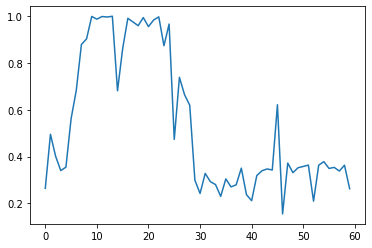

In [141]:
plt.plot(predictions.mean(0)[:,0])

# Inference

In [35]:
def inference_one(bs = 100):
    st = time.time()

    cur_epoch = getCurrentBatch()
    if cur_epoch is None: cur_epoch = 0
    print('completed epochs:', cur_epoch)

    model = TabularModel(n_cont = len(meta_cols), out_sz=360, layers=[500,200], ps=[0.5,0.5], bn_final=True)
    
    model_file_name = modelFileName(return_last=True)
    if model_file_name is not None:
        print('loading model', model_file_name)
        state_dict = torch.load(PATH_WORK/'models'/model_file_name)
        model.load_state_dict(state_dict)
    
    if (not CLOUD) or CLOUD_SINGLE:
        model = model.to(device)
    else:
        model_parallel = dp.DataParallel(model, device_ids=devices)

    setSeeds(SEED + cur_epoch)

    tst_ds = RSNA_DataSet(test_md, test_ids_df, mode='test', bs=bs)
    loader_tst = D.DataLoader(tst_ds, num_workers=8 if CLOUD else 0, batch_size=bs, shuffle=False)
    print('dataset test:', len(tst_ds), 'loader test:', len(loader_tst))

    if CLOUD and (not CLOUD_SINGLE):
        results = model_parallel(test_loop_fn, loader_tst)
        predictions = np.concatenate([results[i][0] for i in range(MAX_DEVICES)])
        indices = np.concatenate([results[i][1] for i in range(MAX_DEVICES)])
        offsets = np.concatenate([results[i][2] for i in range(MAX_DEVICES)])
    else:
        predictions, indices, offsets = test_loop_fn(model, loader_tst, device)

    predictions = predictions[np.argsort(indices)]
    offsets = offsets[np.argsort(indices)]
    assert len(predictions) == len(test_md.SeriesInstanceUID.unique())
    assert np.all(indices[np.argsort(indices)] == np.array(range(len(predictions))))
    
    print('test processing time:', time.time() - st)
    
    return predictions, offsets

In [36]:
DATA_SMALL = False
predictions, offsets = inference_one()

completed epochs: 18
loading model model.b18.f0.v19
adding dummy serieses 186
dataset test: 2400 loader test: 24
B10 -> time passed: 4.704 time per batch: 0.470
B20 -> time passed: 6.391 time per batch: 0.320
test processing time: 7.932620048522949


In [37]:
predictions.mean((0,1))

array([0.11411642, 0.09599437, 0.11162667, 0.11051702, 0.11001215,
       0.11129409], dtype=float32)

In [70]:
predictions.mean((0,1))

array([0.087846, 0.004184, 0.029325, 0.030316, 0.041098, 0.029221], dtype=float32)

In [38]:
sub = pd.DataFrame()
for i, series_id in enumerate(test_md.SeriesInstanceUID.unique()):
    df = test_md.loc[test_md.SeriesInstanceUID == series_id]
    id_column = [a + '_' + b for a in df.SOPInstanceUID for b in all_ich]
    assert (offsets[i] + len(df)) <= 60
    data_sub = pd.DataFrame({'ID':np.array(id_column), 
                             'Label':predictions[i,offsets[i]:(offsets[i] + len(df))].reshape(-1)})
    sub = pd.concat([sub,data_sub], axis=0, sort=False)

sub = sub.reset_index(drop=True)

assert len(sub) == 6*len(test_md)

In [39]:
sub.loc[range(0,len(sub),6), 'Label'].mean()

0.15127398073673248

In [72]:
sub.loc[range(0,len(sub),6), 'Label'].mean()

0.1471214

In [49]:
best_sub = pd.read_csv(PATH/'submission_061.csv')

In [47]:
best_sub.loc[range(0,len(sub),6), 'Label'].mean()

NameError: name 'best_sub' is not defined

In [46]:
sub.to_csv(PATH/'sub.csv', index=False)

In [74]:
np.corrcoef(sub.sort_values('ID').reset_index(drop=True).loc[range(0,len(sub),6), 'Label'], 
            best_sub.sort_values('ID').reset_index(drop=True).loc[range(0,len(sub),6), 'Label'])[0,1]

0.9499705853123557

In [ ]:
kaggle competitions submit rsna-intracranial-hemorrhage-detection -f sub.csv -m "TPU"